# 1 前言
        这个星期看了Andrew Ng的公开课（b站），对深度学习有了一个初步的认识（下文简称DL）。这门课程给了关于DL的底层数学原理以及一些很棒的解读方式，但是如果没有亲自运行总无法真正了解其精髓和所谓“调参”的玄学，于是汇总了Ng视频的内容做一个入门级的NN框架，仅供学习参考。








# 2 NUMPY库搭建神经网络（NN）
        我们仅引入python中的numpy库，看看如何一步步的搭建起一个NN，该框架包含DL入门级的调参方案，包括【初始化方案】，【正则化方案】，【优化下降方案】，【minibatch方案】，【Batch Norm方案】等，基本上将Ng前两周的课程串了起来。理论上来说这是一个从1层到L层的框架（其中1层神经网络被称作logistic回归），在进一步阅读之前，请务必看完了Ng前两周的课程，或者对DL已经有了一个初步的了解，若观看过Ng关于深度学习前两周的视频并做过全面的推导，则能够更好上手。
        Ng的课程涉及到了关于NN相对详尽的数学原理和一些编程实现上的小技巧，且课程给出了较好的数据让我们初步理解调参的过程，搭建一个NN框架，有助于更好的理解神经网络的底层原理，更好地领悟调参这门玄学的奥义，同时有助于加深Ng第三周课程“结构化机器学习”的认识。当然，这是一个入门级的框架，唯一的作用就是加深理解，当下有很多流行的深度学习框架（Keras,Tensorflow），这些稳定健全且实用的框架必然是处理实际问题的的首选。
        本次框架的搭建主要参考了Ng的b站课程和 Kulbear【https://github.com/Kulbear 】的作业，以Ng的课程数据为实例进行模型的运行，以Kulbear给出的参数化方案进行测试。另外，国内也有一些很好的学习网站可供大家参考，在b站视频的下方有相应各种链接。

In [1]:
#引入库:numpy搭建框架, sys报错提示
import numpy as np
import sys

## 2.1 激活函数
    神经网络一般有三个激活函数：sigmoid,relu,tanh，其中tanh可以直接调用库，所以这里只写出sigmoid和relu函数
    激活函数是在前向传播中调用

In [2]:
def sigmoid(Z):
    """
    
    sigmoid 激活函数，将应用于神经网络的最后一层和logistic回归中
    
    输入：
        Z - 来自当前层的Z
    输出：
        A - 当前层的激活值，大小与Z相同
        
    """
    A = 1/(1+np.exp(-Z))
    
    return A

In [3]:
def relu(Z):
    """
    
    relu 激活函数，将应用于神经网络 < L 层
    
    输入：
        Z - 来自当前层的Z
    输出：
        A  - 当前层的激活值，大小与Z相同
        
    """
    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)
 
    return A

## 2.2 初始化参数方案
    初始化参数包括:
        1、最基本的参数W，b的初始化—— def initialize_parameters()
        2、选择优化器momentum时，所需要的中间变量v初始化—— def initialize_momentum()
        3、选择优化器adam时，所需的中间变量v,s的初始化—— def initialize_adam()

In [4]:
def initialize_parameters(layers_dims, init="usual",rdnum=1, init_seed = 3):
    """
    初始化多层网络参数W，b
   
   输入：
        layers_dims - 列表：包含网络中每层的节点数量
        init - 初始化方案，有"usual"和"random"两种
        rdnum - 初始化乘数
        init_seed - 初始化随机因子
    
    输出：
        parameters - 字典变量，包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     Wl - np数组，权重矩阵，维度为（layers_dims [l]，layers_dims [l-1]）
                     bl - np数组，偏向量，维度为（layers_dims [l]，1）
    """
    np.random.seed(init_seed)
    parameters = {}
    L = len(layers_dims)

    if init =="usual":
        for l in range(1,L):
            parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1])* np.sqrt(rdnum / layers_dims[l - 1])
            #parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1])/ np.sqrt(layers_dims[l - 1])
            parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    elif init == "random" :
        for l in range(1,L):
            parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1])*rdnum
            parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
       
    #确保数据正确
    assert(parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
    assert(parameters["b" + str(l)].shape == (layers_dims[l], 1))
        
    return parameters

In [5]:
def initialize_momentum(parameters):
    """
    momentum初始化中间变量
    
    输入：
        parameters - 字典变量，来自def initialize_parameters()的返回值
    输出:
        v - 字典变量，包含梯度的指数加权平均值,包含了以下输入：
            v["dW" + str(l)] = dWl的速度
            v["db" + str(l)] = dbl的速度
    
    """
    L = len(parameters) // 2 
    v = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v

In [6]:
def initialize_adam(parameters):
    """
    adam初始化中间变量v , s

    输入：
        parameters - 字典变量，来自def initialize_parameters()的返回值
    输出：
        v - 字典变量，包含梯度的指数加权平均值
        s - 字典变量，包含平方梯度的指数加权平均值
    
    """
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v,s

## 2.3 前向传播方案
    前向传播是代码中比较容易实现的部分
        1、单层实现：首先我们需要计算输入层（X，A1，A2...AL）经过线性化后得到的(Z1，Z2...ZL)—— def forward_cal_Z()
        2、单层实现：下面就是激活函数，这里分两种正常激活—— def forward_cal_A() 和 dropout方案的激活——def forward_cal_A_dropout()
        3、多层实现：实现L层网络的前向传播——def model_forward()
        

In [7]:
def forward_cal_Z(A_prev,W,b):
    """
    实现前向传播单层的线性计算

    输入：
        A_prev - 来自上一层（或输入数据）的激活值，维度为(上一层节点数，样本数）
        W - 权重矩阵，维度为（当前层节点数，上一层节点数）
        b - 偏向量，numpy向量，维度为（当前层节点数量，1）

    输出：
         Z - 激活函数的输入值
         cache - 一个包含“A”，“W”的元组，存储这些变量以有效地计算后向传递
    """
    Z = np.dot(W,A_prev) + b
    assert(Z.shape == (W.shape[0],A_prev.shape[1]))
    cache = (A_prev,W)
     
    return Z,cache

In [8]:
def forward_cal_A(A_prev,W,b,activation):
    """
    实现前向传播单层的激活

    输入：
        A_prev - 来自上一层（或输入数据）的激活值，维度为(上一层节点数，样本数）
        W - 权重矩阵，维度为（当前层节点数，上一层节点数）
        b - 偏向量，numpy向量，维度为（当前层节点数量，1）
        activation - 选择在此层中使用的激活函数，【"sigmoid" | "relu" | "tanh"】

    输出：
        A - 激活函数的输出，可作为下一层的输入值
        cache - 一个包含“linear_cache”的元组，包含A_prev,W,b，后向传播需要用到
    """
    
    if activation == "sigmoid":
        Z, linear_cache = forward_cal_Z(A_prev, W, b)
        A = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = forward_cal_Z(A_prev, W, b)
        A = relu(Z)
    elif activation == "tanh":
        Z, linear_cache = forward_cal_Z(A_prev, W, b)
        A = np.tanh(Z)
    else:
        print("请选择正确的激活函数")
        sys.exit(1)            
    
    assert(A.shape == (W.shape[0],A_prev.shape[1]))
    cache = linear_cache
    
    return A,cache

In [9]:
def forward_cal_A_dropout(A_prev,W,b,activation,keep_drop=0.5):
    """
    实现具有随机舍弃节点的单层前向传播。
    
    输入：
        A_prev - 来自上一层（或输入数据）的激活值，维度为(上一层节点数，样本数）
        W - 权重矩阵，维度为（当前层节点数，上一层节点数）
        b - 偏向量，numpy向量，维度为（当前层节点数量，1））
        keep_prob  - 删除任意一个隐藏单元的概率为1-keep_prob，取值范围（0，1]，当keep_drop为1时则不舍弃任何点
    输出：
        A - 激活函数的输出，可作为下一层的输入值
        cache - 一个包含“linear_cache”的元组，包含A_prev,W,b,D后向传播需要用到
    """
    
    #启动dropout方案
    D = np.random.rand(A_prev.shape[0], A_prev.shape[1])   
    D = D < keep_drop                             
    A_prev = A_prev * D                                    
    A_prev = A_prev / keep_drop                            
  
    #一般来说中间层不会用到sigmoid激活
    if activation == "sigmoid":
        Z, linear_cache = forward_cal_Z(A_prev, W, b)
        A = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = forward_cal_Z(A_prev, W, b)
        A = relu(Z)
    elif activation == "tanh":
        Z, linear_cache = forward_cal_Z(A_prev, W, b)
        A = np.tanh(Z)
    
    assert(A.shape == (W.shape[0],A_prev.shape[1]))
    cache = (linear_cache,D)
    
    return A, cache

In [10]:
def model_forward(X,parameters,activation,keep_drop):
    """
    实现多层网络的前向传播
    
    输入：
        X - 输入数据，numpy数组，维度为（输入层节点数，样本数）
        parameters - 包含W，b的参数字典，注意这里是经过学习训练后的，而不是初始化的
        
        keep_prob  - 删除任意一个隐藏单元的概率为1-keep_prob，取值范围（0，1]，当keep_drop为1时则不舍弃任何点
    
    输出：
        AL - 最后一层激活值，大小为（1，样本数）
        caches - 包含以下内容的缓存列表，用于后向传播的计算，包含了A，W，b，D，其中D是dropout得到的逻辑矩阵：
                 caches = ( (A0, W1), （(A1, W2）, D1)）...... (（A[L-1], WL）, D[L-1]) )
    """
    caches = []
    L = len(parameters) // 2
    
    #对神经网络进行操作
    if L >=2:
        #先对第一层进行relu计算，第一层无论如何不会使用到“dropout”
        A, cache = forward_cal_A(X, parameters['W' + str(1)], parameters['b' + str(1)], activation)
        caches.append(cache)
    
        #对第二层至第L-1层进行操作
        for l in range(2,L):
            A_prev = A 
            A, cache = forward_cal_A_dropout(A_prev, parameters['W' + str(l)], 
                                                          parameters['b' + str(l)], activation,keep_drop[l-2])
            caches.append(cache)
  
        #对第L层进行操作
        AL, cache = forward_cal_A_dropout(A, parameters['W' + str(L)], 
                                                           parameters['b' + str(L)], "sigmoid",keep_drop[L-2])
        caches.append(cache)
        
    #对logistic回归进行操作 ，这里的激活函数自动选择了sigmoid，可以修改成其他的，有兴趣的也可把它加入到参数化方案中
    else:
        AL, cache = forward_cal_A(X, parameters['W' + str(1)], parameters['b' + str(1)], "sigmoid")
        caches.append(cache)
        
    assert(AL.shape == (1,X.shape[1]))
    
    return AL,caches

## 2.4 计算成本函数

In [11]:
def cost_function(AL,Y):
    """
    计算成本

    输入：
        AL - 最后一层激活值，大小为（1，样本数）
        Y - 标签向量（0|1），维度为（1，样本数）

    输出：
        cost - 交叉熵成本值
    """
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    cross_entropy_cost = 1./m * np.nansum(logprobs)
    #cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m
        
    cross_entropy_cost = np.squeeze(cross_entropy_cost)
    assert(cross_entropy_cost.shape == ())

    return cross_entropy_cost

In [12]:
def compute_cost(AL,Y,parameters,lambd=0):
    """
    包含L2正则化方案的计算成本
    
    输入：
        AL - 最后一层激活值，大小为（1，样本数）
        Y - 标签向量（0|1），维度为（1，样本数）
        parameters - 包含W，b的参数字典，注意这里是经过学习训练后的，而不是初始化的
    输出：
        cost - 包含正则化的成本值
    
    """
    m = Y.shape[1]
    L = len(parameters) // 2
    
    cross_entropy_cost = cost_function(AL,Y)
    
    L2_cost = 0
    #如果lambd不等于0，则采用L2正则化
    if lambd != 0:
        for l in range(L):
            L2_cost = L2_cost + np.sum(np.square(parameters["W"+str(l+1)])) 
        
        L2_cost = lambd * L2_cost / (2 * m)
    
    cost = cross_entropy_cost + L2_cost
    
    return cost

## 2.5 后向传播方案

In [13]:
def backward_cal(dZ,cache,lambd=0):
    """
    实现反向传播单层的线性计算

    输入：
         dZ - 当前层的线性输出的梯度
         cache - 来自当前层前向传播的值的元组（A_prev，W），由前向传播计算获得
         lambd - L2正则参数

    输出：
         dA_prev - 前一层激活值梯度，与A_prev维度相同
         dW - 当前层W的梯度，与W的维度相同
         db - 当前层b梯度，与b维度相同
    """
    A_prev, W = cache
    #A_prev, W = cache
    m = A_prev.shape[1]
    
    if lambd == 0:
        dW = (1. / m) *np.dot(dZ, A_prev.T) 
    else:
        dW = (1. / m) *np.dot(dZ, A_prev.T) + ((lambd * W) / m )

    db = (1. / m) *np.sum(dZ, axis=1, keepdims=True) 
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
        
    return dA_prev, dW, db

In [14]:
def backward_sigmoid(A,Y,cache,keep_drop=1,lambd=0):
    """
    实现反向传播单层的sigmoid计算，计算出dZ并赋值给def backward_cal()
    
    输入：
         A - 当前层的激活值，对于此函数来说是AL
         Y - 计算sigmoid激活的dZ所需的样本标签
         cache - 用于计算反向传播的值的元组, (A0, W1, b1), (A1, W2, b2,D1)...... (A[L-1], WL, bL, D[L-1]) ，由def model_forward()获得
         keep_drop - dropout方案参数
         lambd - L2正则参数
    输出：
         dA_prev - 前一层激活值梯度，与A_prev维度相同
         dW - 当前层W的梯度，与W的维度相同
         db - 当前层b梯度，与b维度相同
         dZ - 当前层Z的梯度值
    """
    linear_cache, D = cache
    
    dZ = A-Y
    dA_prev, dW, db = backward_cal(dZ, linear_cache,lambd)
        
    dA_prev = dA_prev * D          
    dA_prev = dA_prev / keep_drop 
    
    return dA_prev,dW,db,dZ

In [15]:
def backward_relu(dA,A,cache,l,keep_drop=1,lambd=0):
    """
    实现反向传播单层的relu计算，计算出dZ并赋值给def backward_cal()
    
    输入：
         dA - 当前层的激活值的梯度
         A - 当前层的激活值
         cache - 用于计算反向传播的值的元组，由def model_forward()获得
         keep_drop - dropout方案参数
         lambd - L2正则参数
    输出：
         dA_prev - 前一层激活值梯度，与A_prev维度相同
         dW - 当前层W的梯度，与W的维度相同
         db - 当前层b梯度，与b维度相同
         dZ - 当前层Z的梯度值
    """
    # 如果l等于0，则反响传播到了第1层，此时没有Dropout方案
    if l != 0:
        linear_cache, D = cache
    else:
        linear_cache = cache

    dZ = np.multiply(dA, np.int64(A > 0))
    dA_prev, dW, db = backward_cal(dZ, linear_cache,lambd)

        
    if l != 0:
        dA_prev = dA_prev * D          
        dA_prev = dA_prev / keep_drop 
    
    return dA_prev,dW,db,dZ

In [16]:
def backward_tanh(W_next, dZ_next,A, cache,l,keep_drop=1,lambd=0):
    """
    实现反向传播单层的tanh计算，计算出dZ并赋值给def backward_cal()
    
    输入：
         W_next - 下一层（l+1层）的W，即W[l+1]
         dZ_next - 下一层（l+1层）Z的梯度，即Z[l+1]
         cache - 用于计算反向传播的值的元组， 由def model_forward()获得
         keep_drop - dropout方案参数
         lambd - L2正则参数
    输出：
         dA_prev - 前一层激活值梯度，与A_prev维度相同
         dW - 当前层W的梯度，与W的维度相同
         db - 当前层b梯度，与b维度相同
         dZ - 当前层Z的梯度值
    """
    # 如果l等于0，则反响传播到了第1层，此时没有Dropout方案
    if l != 0:
        linear_cache, D = cache
    else:
        linear_cache = cache

    #dZ = relu_backward(dA, activation_cache)
    dZ = np.multiply(np.dot(W_next.T, dZ_next), 1 - np.power(A, 2))
    dA_prev, dW, db = backward_cal(dZ, linear_cache,lambd)

        
    if l != 0:
        dA_prev = dA_prev * D          
        dA_prev = dA_prev / keep_drop 
    
    return dA_prev,dW,db,dZ

In [17]:
def backward_logistic(A,Y,cache,lambd=0):
    """
    专门为实现logistic回归的后向计算sigmoid函数，可参照前面三个函数更改
    
    输入：
         A - 当前层的激活值
         Y - 计算sigmoid激活的dZ所需的样本标签
         cache - 用于计算反向传播的值的元组，由def model_forward()获得
    输出：
         dA_prev - 前一层激活值梯度，这里是指结果值AL
         dW - 当前层W的梯度，与W的维度相同
         db - 当前层b梯度，与b维度相同
         dZ - 当前层Z的梯度值
    """
    linear_cache = cache
    
    dZ = A-Y
    dA_prev, dW, db = backward_cal(dZ, linear_cache,lambd)

    
    return dA_prev,dW,db,dZ

In [18]:
def model_backward(AL,Y,caches,activation,keep_drop,lambd):
    """
    实现多层网络的反向传播
    
    输入：
     AL - 结果值，由def model_forward()获得，维度为（1，样本数）
     Y - 标签向量（0 | 1），维度为（1，样本数）
     caches -用于计算反向传播的值的元组, (A0, W1, b1), (A1, W2, b2,D1)...... (A[L-1], WL, bL, D[L-1]) ，由def model_forward()获得
     activation - 由前向传播决定
     keep_drop - dropout方案参数
     lambd - L2正则参数
    
    输出：
     grads - 梯度值字典：
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
              grads [“dZ”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    keepdrop = 1
    

    if L>=2:
        current_cache = caches[L-1]
        grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)], grads["dZ" + str(L)]= backward_sigmoid(AL, Y, current_cache, keep_drop[L-2], lambd)
        if activation == "relu":
            for l in reversed(range(L-1)):
                current_cache = caches[l]
                A = caches[l+1][0][0]
                #如果l-1大于0，则启动keep_drop进行后向传播
                if (l-1)>=0:
                    keepdrop = keep_drop[l-1]
                dA_prev_temp, dW_temp, db_temp, dZ_temp = backward_relu(grads["dA" + str(l + 2)], A, current_cache, l, keepdrop, lambd)
                grads["dA" + str(l + 1)] = dA_prev_temp
                grads["dW" + str(l + 1)] = dW_temp
                grads["db" + str(l + 1)] = db_temp
                grads["dZ" + str(l + 1)] = dZ_temp
            
        elif activation == "tanh":
            for l in reversed(range(L-1)):
                current_cache = caches[l]
                A = caches[l+1][0][0]
                W_next = caches[l+1][0][1]
                #如果l-1大于0，则启动keep_drop进行后向传播
                if (l-1)>=0:
                    keepdrop = keep_drop[l-1]
                dA_prev_temp, dW_temp, db_temp, dZ_temp = backward_tanh(W_next, grads["dZ" + str(l + 2)],  A, current_cache,l,keepdrop, lambd)
                grads["dA" + str(l + 1)] = dA_prev_temp
                grads["dW" + str(l + 1)] = dW_temp
                grads["db" + str(l + 1)] = db_temp
                grads["dZ" + str(l + 1)] = dZ_temp
                
    else:
        current_cache = caches[L-1]
        grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)], grads["dZ" + str(L)]= backward_logistic(AL,Y, current_cache)
        
    return grads

## 2.6 MINI_BATCH方案

In [19]:
def get_minibataches(X,Y,minibatch_size=64,seed=0):
    """
    打乱原样本并获取minibatch
    
    输入：
        X - 输入数据，维度为(输入节点数量，样本数)
        Y - 样本标签【1 | 0】，维度为(1,样本数)
        minibatch_size - 每个mini-batch的样本数
        seed - 随机因子
        
    输出：
        minibatches - 同步列表，维度为（minibatch_X,minibatch_Y）
        
    """
    #每次执行都会有不同的结果，删除下面一行同样能达到效果
    np.random.seed(seed) #指定随机种子
    m = X.shape[1]
    minibatches = []
    
    #第一步：打乱顺序
    orders = list(np.random.permutation(m))  
    X_split = X[:,orders]    
    Y_split = Y[:,orders]
    
    
    #第二步，分割
    minibatches_slipt = int(m / minibatch_size)+1 #python中多出的列可自动忽略，故+1
    for k in range(0,minibatches_slipt):
        minibatch_X = X_split[:,k * minibatch_size:(k+1)*minibatch_size]
        minibatch_Y = Y_split[:,k * minibatch_size:(k+1)*minibatch_size]

        mini_batch = (minibatch_X,minibatch_Y)
        minibatches.append(mini_batch)

    return minibatches


## 2.7 更新参数方案

In [20]:
def update_parameters(parameters, grads, learning_rate):
    """
    使用正常的梯度下降更新参数
    
    输入：
     parameters - 经过学习训练后的参数
     grads - 包含梯度值的字典，由def model_backward()获得
     learning_rate - 学习率
    输出：
     parameters - 更新参数的字典
                   参数[“W”+ str（l）] = ...
                   参数[“b”+ str（l）] = ...
    """
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [21]:
def update_parameters_momentum(parameters,grads,v,beta,learning_rate):
    """
    momentum更新参数
    输入：
        parameters - 经过学习训练后的参数
        grads -  包含梯度值的字典，由def model_backward()获得
        v - 经过学习训练后的v参数
        beta - 超参数
        learning_rate - 学习率
    输出：
        parameters - 更参数的字典
        v - 更v参数的字典
    """
    L = len(parameters) // 2 
    for l in range(L):
        #计算中间变量v
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]
        
        #更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
    
    return parameters,v

In [22]:
def update_parameters_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    """
    Adam更新参数
    
    输入：
        parameters - 经过学习训练后的参数
        grads -  包含梯度值的字典，由def model_backward()获得
        learning_rate - 学习率
        v - 经过学习训练后的v参数
        s - Adam的中间变量，平方梯度的移动平均值
        t - 当前迭代的次数
        learning_rate - 学习率
        beta1 - 超参数，修正偏差
        beta2 - RMSprop的超参数
        epsilon - 防止除零操作
    
    输出：
        parameters - 更新后的参数
        v - 经过学习训练后的v参数
        s - 经过学习训练后的s参数
    """
    L = len(parameters) // 2
    v_corrected = {} #偏差修正后的值
    s_corrected = {} #偏差修正后的值
    
    for l in range(L):
        
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        
        # v的偏差修正
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1,t))
    
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads["dW" + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads["db" + str(l + 1)])
         
        # s的偏差修正
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2,t))
        
        #更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * (v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * (v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon))
    
    return parameters,v,s

## 2.8 集成模型

In [23]:
def NN_model(X,Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer="normal",beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,
                      is_minibatch=False,minibatch_size=64,print_cost=True,is_plot=True,cost_freq=100, print_freq=100):

    """
    将前面的函数统一调用，实现参数训练
    
    输入：
        X - 输入的数据，维度为(输入层节点数，样本数）
        Y - 标签向量（0 | 1），维度为（1，样本数）
        
        #####基本参数方案#####
        num_iterations - 迭代次数
        activation - 传播过程的激活函数，有sigmoid,relu,tanh三种，最后一层默认sigmoid（可改）
        learning_rate - 学习速率
        
        #####初始化方案#####
        layers_dims - 列表：包含网络中每层的节点数量
        init - 初始化方案，有"usual"和"random"两种
        rdnum - 初始化乘数
        init_seed - 初始化随机因子
        
        #####正则化方案#####
        keep_drop - 删除任意一个隐藏单元的概率为1-keep_prob，取值范围（0，1]，当keep_drop为1时则不舍弃任何点
        lambd - L2正则参数
        
        #####优化算法方案#####
        optimizer="normal"
        beta - momentum的超参数
        beta1 - adam的超参数
        beta2 - adam的超参数
        epsilon - 防止除零操作
               
        #####minibatch方案#####
        is_minibatch - 是否开启minibatch
        minibatch_size - minibatch样本大小
        
        #####打印方案#####
        print_cost=True
        is_plot=True
        cost_freq=1000
        print_freq=1000
    返回
        parameters - 学习后的参数
    """
    if len(layers_dims)==2:
        print("**********************************Logistic回归模型**********************************")
    else:
        print("**********************************"+str(len(layers_dims)-1)+"层神经网络**********************************")
    print()
    
    costs = []
    t = 0 
    seed = 10 

    
    #检验参数是否设置正确
    if len(keep_drop) == 0:
         keep_drop = [1 for _ in range(len(layers_dims)-2)]      
    elif len(keep_drop) != len(layers_dims)-2 :
        print("dropout方案参数异常，长度应为"+str(len(layers_dims)-2))
        sys.exit(1)
    
    #初始化参数
    parameters = initialize_parameters(layers_dims,init,rdnum,init_seed)
    
    #选择优化方案
    if optimizer == "normal":
        pass #不使用任何优化器，直接使用梯度下降法
    elif optimizer == "momentum":
        v = initialize_momentum(parameters) #使用动量
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)#使用Adam优化
    else:
        print("optimizer参数错误")
        sys.exit(1)
        

    #开始学习
    if is_minibatch:
        if X.shape[1]<=minibatch_size:
            print("若开启minibatch，minibatch size需小于样本数")
            sys.exit(1)
        for i in range(0,num_iterations):
            seed = seed + 1
            minibatches = get_minibataches(X,Y,minibatch_size,seed)
            for minibatch in minibatches:
                #选择一个minibatch
                (minibatch_X,minibatch_Y) = minibatch
                #前向传播
                AL , caches = model_forward(minibatch_X,parameters,activation,keep_drop)

                #计算成本
                cost = compute_cost(AL,minibatch_Y,parameters,lambd)
        
                #反向传播
                grads = model_backward(AL,minibatch_Y,caches,activation,keep_drop,lambd)
     
                #更新参数
                if optimizer == "normal":
                    parameters = update_parameters(parameters,grads,learning_rate)
                elif optimizer == "momentum":
                    parameters, v = update_parameters_momentum(parameters,grads,v,beta,learning_rate)
                elif optimizer == "adam":
                    t = t + 1 
                    parameters, v, s = update_parameters_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
        
            #记录并打印成本
            if i % cost_freq == 0:
                ## 记录成本
                costs.append(cost)
                if (print_cost and i % print_freq == 0):
                    #打印成本
                    print("第" + str(i) + "次迭代的成本为：" + str(cost))
        
    else:
        #不启动minibatch方案
        for i in range(0,num_iterations):
            #前向传播
            AL , caches = model_forward(X,parameters,activation,keep_drop)
        
            #计算成本
            cost = compute_cost(AL,Y,parameters,lambd)
        
            #反向传播
            grads = model_backward(AL,Y,caches,activation,keep_drop,lambd)
     
            #更新参数
            if optimizer == "normal":
                parameters = update_parameters(parameters,grads,learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_momentum(parameters,grads,v,beta,learning_rate)
            elif optimizer == "adam":
                t = t + 1 
                parameters, v, s = update_parameters_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
 
        
            #记录打印成本
            if i % cost_freq == 0:
                ## 记录成本
                costs.append(cost)
                if (print_cost and i % print_freq == 0):
                    #打印成本
                    print("第" + str(i) + "次迭代的成本为：" + str(cost))
        
        
    
    #是否绘制成本曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    #学习后的参数
    return parameters

## 2.9 预测

In [24]:
def predict(X, y, parameters,activation):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层
    
    输入：
     X - 测试集
     y - 标签
     parameters - 训练获得的参数
    
    输出：
     prediction - 给定数据集X的预测
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    #p = np.zeros((1,m))
    #生成全部由1组成的列表
    keep_drop = [1 for _ in range(n+1)]
    
    
    #根据参数前向传播
    AL, caches = model_forward(X, parameters,activation,keep_drop)

    prediction = np.round(AL)
    print("准确度为: "  + str(float(np.sum((prediction == y))/m)))
        
    return prediction

## 2.10 回顾

# 3 运行/测试模型
        以下数据由Ng课程提供，并由【 Kulbear 】给出了较好的调参方案，以用于模型运行和测试。
        如有兴趣，可去https://github.com/Kulbear/deep-learning-coursera 对比效果

In [25]:
# load_units用于读取测试数据，matplotlib用于画图
import matplotlib.pyplot as plt
import load_utils  

In [26]:
#用于绘制边界的函数，由Kulbear 提供
def predict_dec(parameters,activation,X):
    """
    使用学习的参数，为X中的每个示例预测一个类
    
    输入：
		parameters - 包含参数的字典类型的变量。
	    X - 输入数据（n_x，m）
    
    返回
		predictions - 我们模型预测的向量（红色：0 /蓝色：1）
     
     """
    n = len(parameters) // 2
    keep_drop = [1 for _ in range(n+1)]
    
    AL , cache =  model_forward(X, parameters,activation,keep_drop)
    predictions = np.round(AL)
    
    return predictions

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

## 3.1 猫咪识别

In [27]:
#加载数据
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_utils.load_dataset_cat()

#数据预处理
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

#################################### 默认调参列表 ####################################

#基本参数方案
num_iterations =2000
activation = "relu"
learning_rate=0.005
#初始化方案
layers_dims = []
init = "random"
rdnum = 0
init_seed = 1
#优化算法方案
optimizer="normal"
beta=0.9
beta1=0.9
beta2=0.999
epsilon=1e-8
#正则化方案
keep_drop = [] 
lambd=0
#minibatch方案
is_minibatch = False
minibatch_size=64
#打印方案
print_cost=True
is_plot=True
cost_freq=100
print_freq=100

#################################### 默认调参列表 ####################################

### 3.1.1 logistic回归

**********************************Logistic回归模型**********************************

第0次迭代的成本为：0.6931471805599453
第100次迭代的成本为：0.5845083636993086
第200次迭代的成本为：0.4669490409465547
第300次迭代的成本为：0.37600686694802077
第400次迭代的成本为：0.3314632893282512
第500次迭代的成本为：0.30327306747438293
第600次迭代的成本为：0.2798795865826048
第700次迭代的成本为：0.2600421369258757
第800次迭代的成本为：0.2429406846779662
第900次迭代的成本为：0.22800422256726066
第1000次迭代的成本为：0.21481951378449635
第1100次迭代的成本为：0.20307819060644988
第1200次迭代的成本为：0.19254427716706862
第1300次迭代的成本为：0.18303333796883509
第1400次迭代的成本为：0.1743985943844888
第1500次迭代的成本为：0.16652139705400335
第1600次迭代的成本为：0.15930451829756614
第1700次迭代的成本为：0.15266732471296504
第1800次迭代的成本为：0.1465422350398234
第1900次迭代的成本为：0.14087207570310162


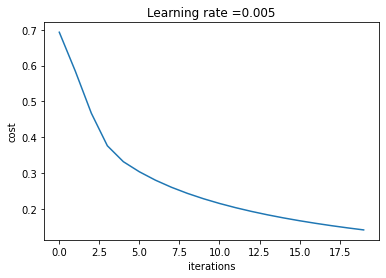

训练集:
准确度为: 0.9904306220095693
测试集:
准确度为: 0.7


In [28]:
#################################### 调参列表 ####################################

#初始化方案
layers_dims = [12288,1]

#################################### 调参列表 ####################################

parameters = NN_model(train_x, train_y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
predictions_train = predict(train_x, train_y, parameters,activation)
print("测试集:")
predictions_test = predict(test_x, test_y, parameters,activation)

### 3.1.2 两层神经网络

**********************************2层神经网络**********************************

第0次迭代的成本为：0.693049735659989
第100次迭代的成本为：0.6464320953428849
第200次迭代的成本为：0.6325140647912677
第300次迭代的成本为：0.6015024920354665
第400次迭代的成本为：0.5601966311605747
第500次迭代的成本为：0.5158304772764729
第600次迭代的成本为：0.47549013139433266
第700次迭代的成本为：0.43391631512257495
第800次迭代的成本为：0.40079775362038894
第900次迭代的成本为：0.3580705011323798
第1000次迭代的成本为：0.3394281538366412
第1100次迭代的成本为：0.3052753636196264
第1200次迭代的成本为：0.2749137728213017
第1300次迭代的成本为：0.2468176821061485
第1400次迭代的成本为：0.19850735037466097
第1500次迭代的成本为：0.17448318112556593
第1600次迭代的成本为：0.17080762978095973
第1700次迭代的成本为：0.11306524562164738
第1800次迭代的成本为：0.09629426845937158
第1900次迭代的成本为：0.08342617959726865
第2000次迭代的成本为：0.07439078704319083
第2100次迭代的成本为：0.06630748132267929
第2200次迭代的成本为：0.059193295010381675
第2300次迭代的成本为：0.05336140348560553
第2400次迭代的成本为：0.04855478562877016


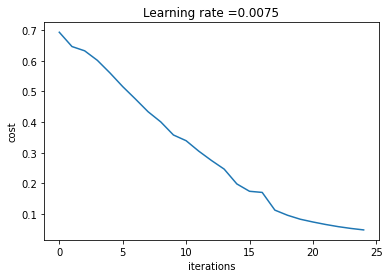

训练集:
准确度为: 1.0
测试集:
准确度为: 0.72


In [29]:
#################################### 调参列表 ####################################

#基本参数方案
num_iterations = 2500
learning_rate=0.0075
#初始化方案
layers_dims = [12288,7,1]
rdnum = 0.01

#################################### 调参列表 ####################################

parameters = NN_model(train_x, train_y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
predictions_train = predict(train_x, train_y, parameters,activation)
print("测试集:")
predictions_test = predict(test_x, test_y, parameters,activation)

### 3.1.3 四层神经网络

**********************************4层神经网络**********************************

第0次迭代的成本为：0.7157315134137129
第100次迭代的成本为：0.6747377593469114
第200次迭代的成本为：0.6603365433622127
第300次迭代的成本为：0.6462887802148751
第400次迭代的成本为：0.6298131216927771
第500次迭代的成本为：0.606005622926534
第600次迭代的成本为：0.5690041263975134
第700次迭代的成本为：0.519796535043806
第800次迭代的成本为：0.46415716786282296
第900次迭代的成本为：0.40842030048298916
第1000次迭代的成本为：0.37315499216069065
第1100次迭代的成本为：0.30572374573047134
第1200次迭代的成本为：0.2681015284774087
第1300次迭代的成本为：0.23872474827672438
第1400次迭代的成本为：0.20632263257914704
第1500次迭代的成本为：0.17943886927493394
第1600次迭代的成本为：0.15798735818800208
第1700次迭代的成本为：0.1424041301227261
第1800次迭代的成本为：0.12865165997879036
第1900次迭代的成本为：0.1124431499813411
第2000次迭代的成本为：0.08505631034928772
第2100次迭代的成本为：0.05758391198579492
第2200次迭代的成本为：0.044567534546811775
第2300次迭代的成本为：0.038082751665914204
第2400次迭代的成本为：0.03441074901836243


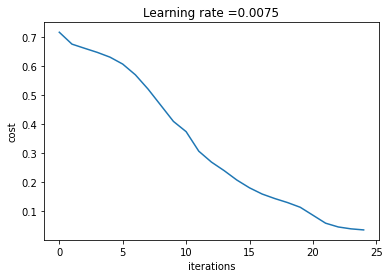

训练集:
准确度为: 0.9952153110047847
测试集:
准确度为: 0.78


In [30]:
#################################### 调参列表 ####################################

#基本参数方案
num_iterations = 2500
learning_rate=0.0075
#初始化方案
layers_dims = [12288, 20, 7, 5, 1] 
init = "usual"
rdnum = 1
init_seed = 3

#################################### 调参列表 ####################################

parameters = NN_model(train_x, train_y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
predictions_train = predict(train_x, train_y, parameters,activation)
print("测试集:")
predictions_test = predict(test_x, test_y, parameters,activation)

## 3.2 散点二分类

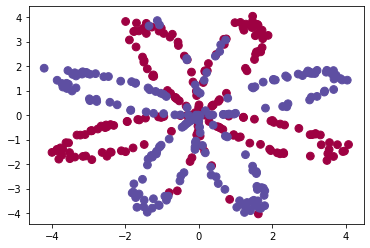

In [31]:
#加载数据
train_X, train_Y = load_utils.load_dataset_flower(is_plot=True)


#################################### 默认调参列表 ####################################

#基本参数方案
num_iterations = 10000
activation = "sigmoid"
learning_rate=1.2
#初始化方案
layers_dims = []
init = "random"
rdnum = 0.01
init_seed = 2
#优化算法方案
optimizer="normal"
beta=0.9
beta1=0.9
beta2=0.999
epsilon=1e-8
#正则化方案
keep_drop = []
lambd=0
#minibatch方案
is_minibatch = False
minibatch_size=64
#打印方案
print_cost=True
is_plot=True
cost_freq=1000
print_freq=1000

#################################### 默认调参列表 ####################################

### 3.2.1 logistic回归

**********************************Logistic回归模型**********************************

第0次迭代的成本为：0.6931389866565596
第1000次迭代的成本为：0.6731461686074701
第2000次迭代的成本为：0.6731461686074701
第3000次迭代的成本为：0.6731461686074701
第4000次迭代的成本为：0.6731461686074701
第5000次迭代的成本为：0.6731461686074701
第6000次迭代的成本为：0.6731461686074701
第7000次迭代的成本为：0.6731461686074701
第8000次迭代的成本为：0.6731461686074701
第9000次迭代的成本为：0.6731461686074701


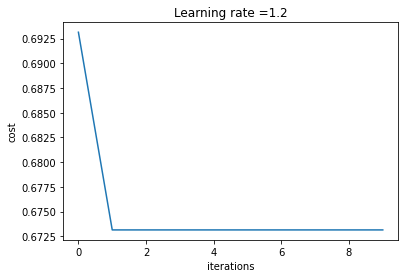

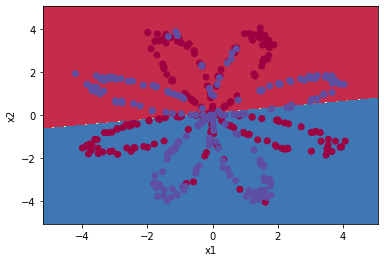

In [32]:
#################################### 调参列表 ####################################

#初始化方案
layers_dims = [train_X.shape[0], 1] 

#################################### 调参列表 ####################################

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#绘制边界
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


### 3.2.2 两层神经网络

**********************************2层神经网络**********************************

第0次迭代的成本为：0.6930480201239823
第1000次迭代的成本为：0.2880832935690184
第2000次迭代的成本为：0.25438549407324557
第3000次迭代的成本为：0.23386415038952207
第4000次迭代的成本为：0.2267924874485401
第5000次迭代的成本为：0.22264427549299015
第6000次迭代的成本为：0.21973140404281322
第7000次迭代的成本为：0.21750365405131297
第8000次迭代的成本为：0.21947125887325217
第9000次迭代的成本为：0.21861159124673285


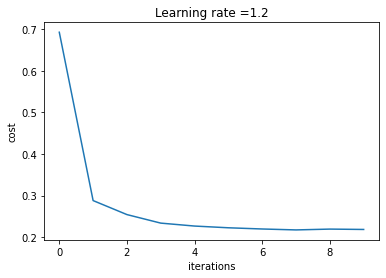

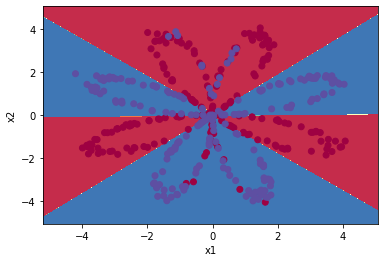

In [33]:
#################################### 调参列表 ####################################

#基本参数方案
activation = "tanh"
#初始化方案
layers_dims = [train_X.shape[0], 4, 1] 

#################################### 调参列表 ####################################

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#绘制边界
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


## 3.3 初始化测试

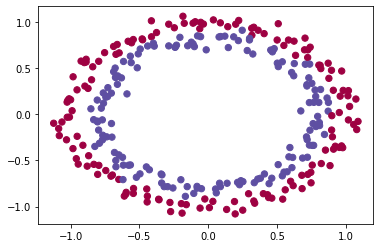

In [34]:
#加载数据
train_X, train_Y, test_X, test_Y = load_utils.load_dataset_init(is_plot=True)

#################################### 默认调参列表 ####################################

#基本参数方案
num_iterations = 15000
activation = "relu"
learning_rate=0.01
#初始化方案
layers_dims = [train_X.shape[0],10,5,1]
init = "random"
rdnum = 10
init_seed = 3
#优化算法方案
optimizer="normal"
beta=0.9
beta1=0.9
beta2=0.999
epsilon=1e-8
#正则化方案
keep_drop = [] 
lambd=0
#minibatch方案
is_minibatch = False
minibatch_size=64
#打印方案
print_cost=True
is_plot=True
cost_freq=1000
print_freq=1000

#################################### 默认调参列表 ####################################

### 3.3.1 随机初始化

**********************************3层神经网络**********************************

第0次迭代的成本为：inf


/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


第1000次迭代的成本为：0.6233411191151289
第2000次迭代的成本为：0.5979975786826551
第3000次迭代的成本为：0.5637219993907252
第4000次迭代的成本为：0.5501747010826686
第5000次迭代的成本为：0.5444870298201837
第6000次迭代的成本为：0.5374760938753197
第7000次迭代的成本为：0.4785905093963044
第8000次迭代的成本为：0.3978609117048426
第9000次迭代的成本为：0.393485932269449
第10000次迭代的成本为：0.3920329845328833
第11000次迭代的成本为：0.389293077010843
第12000次迭代的成本为：0.38615359364857854
第13000次迭代的成本为：0.3849922239407539
第14000次迭代的成本为：0.38280353580966076


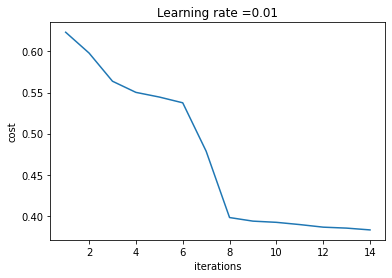

训练集:
准确度为: 0.83
测试集:
准确度为: 0.86


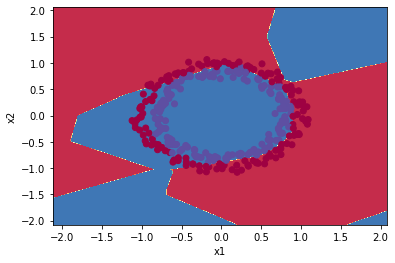

In [35]:
#################################### 调参列表 ####################################

#初始化方案
init = "random"
rdnum = 10
init_seed = 3

#################################### 调参列表 ####################################

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
predictions_train = predict(train_X, train_Y, parameters,activation)
print("测试集:")
predictions_test = predict(test_X, test_Y, parameters,activation)

#绘制边界
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


### 3.3.2 常规初始化

**********************************3层神经网络**********************************

第0次迭代的成本为：0.8830537463419761
第1000次迭代的成本为：0.6879825919728063
第2000次迭代的成本为：0.6751286264523371
第3000次迭代的成本为：0.6526117768893807
第4000次迭代的成本为：0.6082958970572938
第5000次迭代的成本为：0.5304944491717495
第6000次迭代的成本为：0.4138645817071793
第7000次迭代的成本为：0.3117803464844441
第8000次迭代的成本为：0.23696215330322562
第9000次迭代的成本为：0.18597287209206836
第10000次迭代的成本为：0.15015556280371817
第11000次迭代的成本为：0.12325079292273548
第12000次迭代的成本为：0.09917746546525935
第13000次迭代的成本为：0.08457055954024276
第14000次迭代的成本为：0.0735789596267737


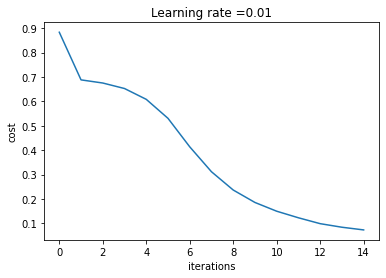

训练集:
准确度为: 0.9933333333333333
测试集:
准确度为: 0.96


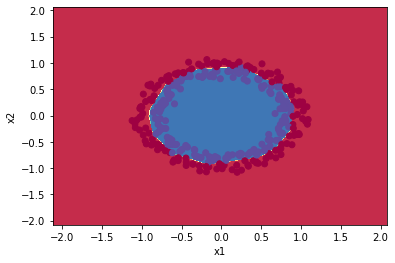

In [36]:
#################################### 调参列表 ####################################

#初始化方案
init = "usual"
rdnum = 2
init_seed = 3

#################################### 调参列表 ####################################

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
predictions_train = predict(train_X, train_Y, parameters,activation)
print("测试集:")
predictions_test = predict(test_X, test_Y, parameters,activation)

#绘制边界
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


## 3.4 正则化测试

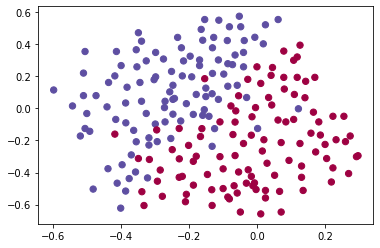

In [37]:
##加载数据
train_X, train_Y, test_X, test_Y = load_utils.load_dataset_2D(is_plot=True)

In [38]:
#################################### 默认调参列表 ####################################

#基本参数方案
num_iterations = 30000
activation = "relu"
learning_rate=0.3
#初始化方案
layers_dims = [train_X.shape[0],20,3,1]
init = "usual"
rdnum = 1
init_seed = 3
#优化算法方案
optimizer="normal"
beta=0.9
beta1=0.9
beta2=0.999
epsilon=1e-8
#正则化方案
keep_drop = [] 
lambd=0
#minibatch方案
is_minibatch = False
minibatch_size=64
#打印方案
print_cost=True
is_plot=True
cost_freq=1000
print_freq=10000

#################################### 默认调参列表 ####################################

### 3.4.1 不使用任何正则化方案

**********************************3层神经网络**********************************

第0次迭代的成本为：0.6557412523481002
第10000次迭代的成本为：0.16329987525724204
第20000次迭代的成本为：0.13851642423258356


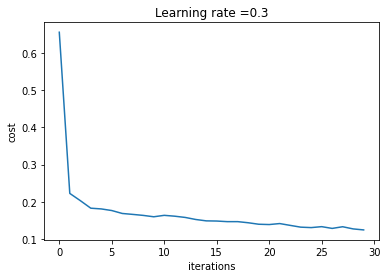

训练集:
准确度为: 0.9478672985781991
测试集:
准确度为: 0.915


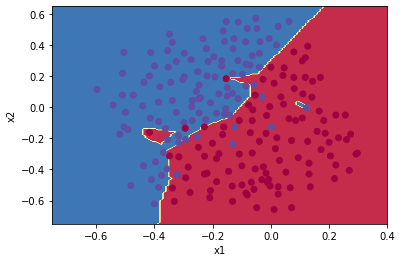

In [39]:

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
predictions_train = predict(train_X, train_Y, parameters,activation)
print("测试集:")
predictions_test = predict(test_X, test_Y, parameters,activation)

#绘制边界
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


### 3.4.3 L2正则化方案

**********************************3层神经网络**********************************

第0次迭代的成本为：0.6974484493131264
第10000次迭代的成本为：0.2684918873282239
第20000次迭代的成本为：0.2680916337127301


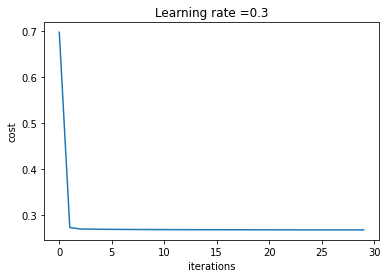

训练集:
准确度为: 0.9383886255924171
测试集:
准确度为: 0.93


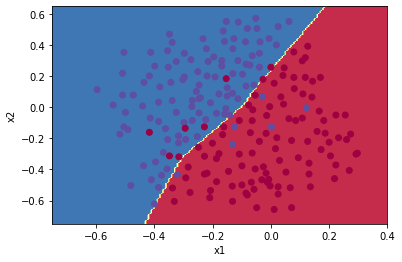

In [40]:
#################################### 调参列表 ####################################

#正则化方案
lambd=0.7

#################################### 调参列表 ####################################

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
predictions_train = predict(train_X, train_Y, parameters,activation)
print("测试集:")
predictions_test = predict(test_X, test_Y, parameters,activation)

#绘制边界
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


### 3.4.2 Dropout方案

**********************************3层神经网络**********************************

第0次迭代的成本为：0.6579307804914392
第10000次迭代的成本为：0.2053274052858062
第20000次迭代的成本为：0.18147395870629873


/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


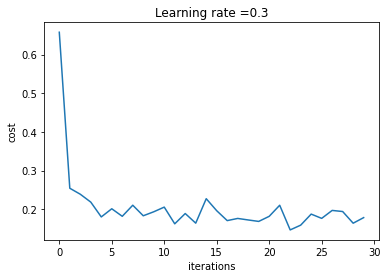

训练集:
准确度为: 0.9478672985781991
测试集:
准确度为: 0.935


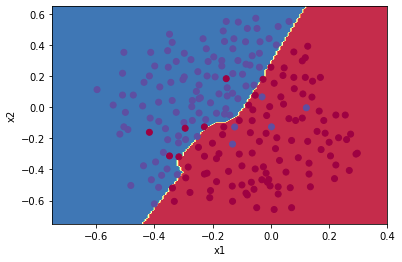

In [41]:
#################################### 调参列表 ####################################

#正则化方案
keep_drop = [0.86,0.86] 
lambd = 0 #关闭L2正则

#################################### 调参列表 ####################################

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
predictions_train = predict(train_X, train_Y, parameters,activation)
print("测试集:")
predictions_test = predict(test_X, test_Y, parameters,activation)

#绘制边界
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


## 3.5 优化算法测试

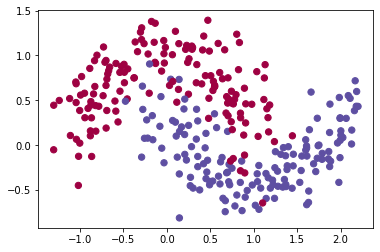

In [42]:
#加载数据
train_X, train_Y = load_utils.load_dataset_mini(is_plot=True)

#################################### 默认调参列表 ####################################

#基本参数方案
num_iterations = 10000
activation = "relu"
learning_rate=0.0007
#初始化方案
layers_dims = [train_X.shape[0],5,2,1]
init = "usual"
rdnum = 2
init_seed = 3
#优化算法方案
optimizer="normal"
beta=0.9
beta1=0.9
beta2=0.999
epsilon=1e-8
#正则化方案
keep_drop = []  
lambd=0
#minibatch方案
is_minibatch = True    #开启minibatch
minibatch_size=64
#打印方案
print_cost=True
is_plot=True
cost_freq=100
print_freq=1000

#################################### 默认调参列表 ####################################

### 3.5.1 常规梯度下降

**********************************3层神经网络**********************************

第0次迭代的成本为：0.690735512291113
第1000次迭代的成本为：0.6852725328458241
第2000次迭代的成本为：0.6470722240719003
第3000次迭代的成本为：0.6195245549970403
第4000次迭代的成本为：0.5765844355950945
第5000次迭代的成本为：0.6072426395968576
第6000次迭代的成本为：0.5294033317684574
第7000次迭代的成本为：0.46076823985930115
第8000次迭代的成本为：0.4655860823990451
第9000次迭代的成本为：0.4645179722167684


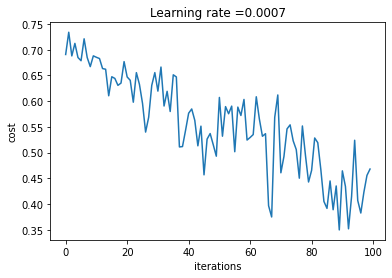

训练集:
准确度为: 0.7966666666666666


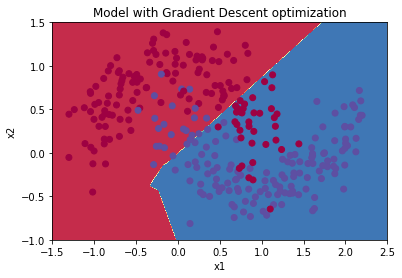

In [43]:

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
preditions = predict(train_X, train_Y, parameters,activation)

#绘制边界
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


### 3.5.2 Momentum优化下降

**********************************3层神经网络**********************************

第0次迭代的成本为：0.6907412988351506
第1000次迭代的成本为：0.6853405261267578
第2000次迭代的成本为：0.6471448370095255
第3000次迭代的成本为：0.6195943032076022
第4000次迭代的成本为：0.5766650344073023
第5000次迭代的成本为：0.607323821900647
第6000次迭代的成本为：0.5294761758786997
第7000次迭代的成本为：0.46093619004872366
第8000次迭代的成本为：0.465780093701272
第9000次迭代的成本为：0.4647395967922748


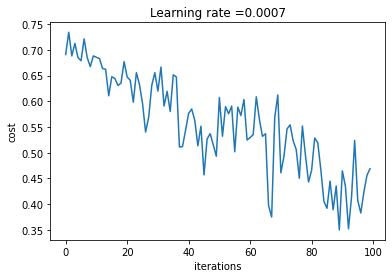

训练集:
准确度为: 0.7966666666666666


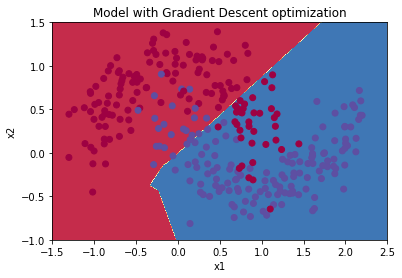

In [44]:
#################################### 调参列表 ####################################

optimizer="momentum"

#################################### 调参列表 ####################################

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
preditions = predict(train_X, train_Y, parameters,activation)

#绘制边界
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


### 3.5.3 Adam优化下降

**********************************3层神经网络**********************************

第0次迭代的成本为：0.6905522446113365
第1000次迭代的成本为：0.18550136438550574
第2000次迭代的成本为：0.15083046575253206
第3000次迭代的成本为：0.0744543857099718
第4000次迭代的成本为：0.1259591565133716
第5000次迭代的成本为：0.10434443534245479
第6000次迭代的成本为：0.10067637504120647
第7000次迭代的成本为：0.031652030135115604
第8000次迭代的成本为：0.11197273131244197
第9000次迭代的成本为：0.19794007152465484


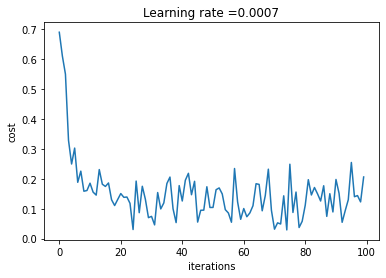

训练集:
准确度为: 0.94


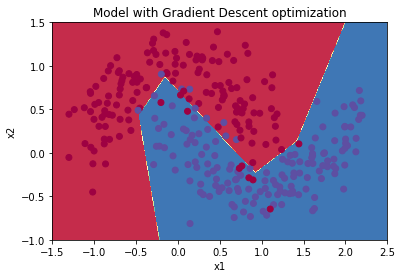

In [45]:
#################################### 调参列表 ####################################

optimizer="adam"

#################################### 调参列表 ####################################

parameters = NN_model(train_X, train_Y,num_iterations,activation,learning_rate,layers_dims,init,rdnum,init_seed,
                    keep_drop,lambd,optimizer,beta,beta1,beta2,epsilon,is_minibatch,minibatch_size,print_cost,is_plot,cost_freq, print_freq)

#预测模型
print("训练集:")
preditions = predict(train_X, train_Y, parameters,activation)

#绘制边界
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, activation, x.T), train_X, train_Y)


## Batch 归一方案